# Pose representation and operations tutorial


## Packages

We will use the `geometry` library to do operations with coordinate frames,
and the Numpy library. We will abbreviate them as `g` and `np`, respectively.


In [1]:
from math import cos, sin, pi
from typing import Tuple

import geometry as g
import numpy as np

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /opt/conda/lib/python3.9/site-packages


# Angles

In code, angles are *always* represented in radians.

The only place where degrees might be acceptable is in configuration files
that need to be edited by users.

Use the functions `np.deg2rad` and `np.rad2deg` to convert back and forth.

In [2]:
from matplotlib import pyplot as plt

assert np.allclose(np.deg2rad(60), np.pi/3)
assert np.allclose(np.rad2deg(np.pi/3), 60)

The function `np.allclose` allows to compare two numbers allowing some tolerance to 
tolerate numerical errors.

## Pose representations

To create a pose from translation, angle (in radians), use the function `SE2_from_translation_angle(translation, angle)`:


In [3]:
translation = [0, 1]
angle = np.pi/3
q = g.SE2_from_translation_angle(translation, angle)

This returns a 3 by 3 matrix:

In [4]:
print(q)

[[ 0.5       -0.8660254  0.       ]
 [ 0.8660254  0.5        1.       ]
 [ 0.         0.         1.       ]]


Use the function `g.SE2.friendly()` to print a nice representation of the matrix:


In [5]:
print(g.SE2.friendly(q))

Pose(Rot(60.0deg),[0. 1.])


To convert back to position, angle use the function `translation_angle_from_SE2`


In [6]:
position, direction = g.translation_angle_from_SE2(q)
print(position)
print(direction)

[0. 1.]
1.0471975511965976


## Operations on poses

The object `geometry.SE2` is a representation of the group SE(2).

It provides the operations `multiply`, `identity`, and `inverse`:


In [7]:
q1 = g.SE2_from_translation_angle([1, 2], np.deg2rad(15))
q2 = g.SE2_from_translation_angle([2, 3], np.deg2rad(30))

# let's compute the relative pose of q2 wrt q1
q2_from_q1 = g.SE2.multiply(g.SE2.inverse(q1), q2)

# now let's re-find q2 by adding the relative pose to q1
q2b = g.SE2.multiply(q1, q2_from_q1)

# this must be equal to q2
assert np.allclose(q2, q2b)

Note that for SE(2) the operations `inverse` and `multiply` correspond to the numpy operations of
matrix inversion `np.linalg.inv` and matrix multiplication `np.dot()` (do not confuse with `np.multiply()` which multiplies element-wise) or using the operator `@`.

## Interpolation of poses

Suppose you want to interpolate between two poses. This is the right way to do it.

First, compute the relative pose:


In [8]:
q2_from_q1 = g.SE2.multiply( g.SE2.inverse(q1), q2)
print(q2_from_q1)

[[ 0.96592583 -0.25881905  1.22474487]
 [ 0.25881905  0.96592583  0.70710678]
 [ 0.          0.          1.        ]]


Now compute the equivalent "velocity". 

The function `algebra_from_group` computes
the element of the algebra of SE(2); that is, *skew symmetric matrices* that 
represent velocities:

In [9]:
vel = g.SE2.algebra_from_group(q2_from_q1)

The set of velocities on $SE(2)$ is called the *lie algebra* $se(2)$.
It is represented by the object `se2`:

In [10]:
g.se2.belongs(vel)
print(g.se2.friendly(vel))

[[ 0.         -0.26179939  1.3103017 ]
 [ 0.26179939  0.          0.54274474]
 [ 0.          0.          0.        ]]


The velocity can be converted to angular, linear components:

In [11]:
linear, angular = g.linear_angular_from_se2(vel)
print('linear: {}'.format(linear))
print('angular: {}'.format(angular))

linear: [1.3103017  0.54274474]
angular: 0.26179938779914946


Now, suppose that you want to interpolate smoothly according to a parameter `alpha`,
such that `alpha = 0` gives `q1` and `alpha = 1` gives `q2`.

You can do that by interpolating linearly in the velocity space:

In [12]:
alpha = 0.5
rel = g.SE2.group_from_algebra(vel * alpha)
q_alpha = g.SE2.multiply( q1, rel)
print(g.SE2.friendly(q_alpha))

Pose(Rot(22.5deg),[1.53277173 2.46722827])


In [13]:
def relative_pose(q0, q1):
    return g.SE2.multiply(g.SE2.inverse(q0), q1)

def interpolate(q0, q1, alpha):
    q1_from_q0 = relative_pose(q0, q1)
    vel = g.SE2.algebra_from_group(q1_from_q0)
    rel = g.SE2.group_from_algebra(vel * alpha)
    q = g.SE2.multiply(q0, rel)
    return q

# sample two poses
q0 = g.SE2.sample_uniform()
q1 = g.SE2.sample_uniform()

# make sure that for alpha=0,1 we get q0,q1
assert np.allclose(q0, interpolate(q0, q1, 0))
assert np.allclose(q1, interpolate(q0, q1, 1))



Let's visualize the result

In [14]:
def arrow_from_SE2(p: g.SE2value, l: float = .1) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    # utility function for plotting arrows from SE2 elements
    xytheta = g.xytheta_from_SE2(p)
    x, y, theta = xytheta
    dx = cos(theta) * l
    dy = sin(theta) * l
    return (x, y), (dx, dy)

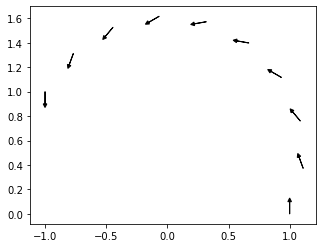

In [15]:
q0 = g.SE2_from_xytheta([1, 0, pi / 2])
q1 = g.SE2_from_xytheta([-1, 1, 3*pi / 2 - .0006])


alphas = np.linspace(0, 1, 10)
ax = plt.axes()
ax.set_aspect('equal')
for alpha in alphas:
    q = interpolate(q0, q1, alpha)
    xy, dxdy = arrow_from_SE2(q)
    ax.arrow(*xy, *dxdy, head_width=0.03, head_length=0.03, fc='k', ec='k')
plt.show()

## Exercise 1
Compare the interpolation above with one done component-wise (i.e. linearly interpolate x,y,theta)

## Exercise 2

We stand back to back.

I walk 3 meters forward; I rotate 20 deg to my right; I walk 7 meters forward.

You walk 2 meters forward, you rotate 30 deg to your left, you go 6 meters forward.

What is the distance between us?

At what angle I see you on my field of view? (0=front, pi/2 = left, -pi/2 = right, -pi=pi back) 